[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/pytorch/rl/blob/main/tutorials/envs.ipynb)

# TorchRL envs (`torchrl.envs`)

Environments play a crucial role in RL settings, often somewhat similar to datasets in supervised and unsupervised settings.
The RL community has become quite familiar with OpenAI gym API which offers a flexible way of building environments, initializing them and interacting with them. 
However, many other libraries exist, and the way one interacts with them can be quite different from what is expected with gym.

Let us start by describing how TorchRL interacts with gym, which will serve as an introduction to other frameworks.

In [ ]:
!pip install functorch torchvision
!pip install "gym[classic_control]"
!pip install dm_control matplotlib
!pip install torchrl

## Gym environments

To run this part of the tutorial, you will need to have a recent version of the gym library installed, as well as the atari suite.
You can get this installed by installing the following packages:

```
pip install gym atari-py ale-py gym[accept-rom-license] pygame
```

To unify all frameworks, torchrl environments are built inside the `__init__` method with a private method called `_build_env` that will pass the arguments and keyword arguments to the root library builder.

With gym, it means that building an environment is as easy as:

In [1]:
from torchrl.envs.libs.gym import GymEnv
from matplotlib import pyplot as plt
from torchrl.data import TensorDict
import torch
env = GymEnv("Pendulum-v1")

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


The list of available environment can be accessed through this command:

In [2]:
GymEnv.available_envs[:10]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 'ALE/Alien-v5',
 'ALE/Amidar-ram-v5',
 'ALE/Amidar-v5',
 'ALE/Assault-ram-v5',
 'ALE/Assault-v5']

### Env specs

Like other frameworks, TorchRL envs have attributes that indicate what space is for the observations, action and reward. 
Because it often happens that more than one observation is retrieved, we expect the observation spec to be of type `CompositeSpec`. Reward and action do not have this restriction:

In [3]:
print("Env observation_spec: \n", env.observation_spec)
print("Env action_spec: \n", env.action_spec)
print("Env reward_spec: \n", env.reward_spec)

Env observation_spec: 
 CompositeSpec(
    next_observation: NdBoundedTensorSpec(
         shape=torch.Size([3]), space=ContinuousBox(minimum=tensor([-1., -1., -8.]), maximum=tensor([1., 1., 8.])), device=cpu, dtype=torch.float32, domain=continuous))
Env action_spec: 
 NdBoundedTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=tensor([-2.]), maximum=tensor([2.])), device=cpu, dtype=torch.float32, domain=continuous)
Env reward_spec: 
 UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=-inf, maximum=inf), device=cpu, dtype=torch.float32, domain=composite)


Those spec come with a series of useful tools: one can assert whether a sample is in the defined space. We can also use some heuristic to project a sample in the space if it is out of space, and generate random (possibly uniformly distributed) numbers in that space:

In [4]:
action = torch.ones(1) * 3
print("action is in bounds?\n", bool(env.action_spec.is_in(action)))
print("projected action: \n", env.action_spec.project(action))


action is in bounds?
 False
projected action: 
 tensor([2.])


In [5]:
print("random action: \n", env.action_spec.rand())

random action: 
 tensor([-0.8754])


Envs are also packed with an `env.input_spec` attribute of type `CompositeSpec`. In brief, `input_spec` should contain all the specs of the inputs that are required for an env to exectute a step. For stateful envs (e.g. gym) this should include the action.
With stateless environments (e.g. Brax) this should also include a representation of the previous state. 

### Seeding, resetting and steps

The basic operations on an environment are (1) `set_seed`, (2) `reset` and (3) `step`.

Let's see how these methods work with TorchRL:

In [6]:
torch.manual_seed(0)  # make sure that all torch code is also reproductible
env.set_seed(0)
tensordict = env.reset()
print(tensordict)

TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        observation: Tensor(torch.Size([3]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


We can now execute a step in the environment. 
Since we don't have a policy, we can just generate a random action:

In [7]:
def policy(tensordict):
    tensordict.set("action", env.action_spec.rand())
    return tensordict
policy(tensordict)
tensordict_out = env.step(tensordict)

By default, the tensordict returned by `step` is the same as the input...

In [8]:
assert tensordict_out is tensordict

... but with new keys

In [9]:
tensordict

TensorDict(
    fields={
        action: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        next_observation: Tensor(torch.Size([3]), dtype=torch.float32),
        observation: Tensor(torch.Size([3]), dtype=torch.float32),
        reward: Tensor(torch.Size([1]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

What we just did (a random step using `action_spec.rand()`) can also be done via the simple shortcut

In [10]:
env.rand_step()

TensorDict(
    fields={
        action: Tensor(torch.Size([1]), dtype=torch.float32),
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        next_observation: Tensor(torch.Size([3]), dtype=torch.float32),
        reward: Tensor(torch.Size([1]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

The new key `"next_observation"` (as all keys starting with `"next_"`) have a special role in TorchRL: they indicate that they come after the key with the same name but without the prefix.

We provide a function `step_mdp` that executes a step in the tensordict: it returns a new tensordict updated such that $t <- t'$:

In [11]:
from torchrl.envs.utils import step_mdp
tensordict.set("some other key", torch.randn(1))
tensordict_tprime = step_mdp(tensordict)
print(tensordict_tprime)
print((tensordict_tprime.get("observation") == tensordict.get("next_observation")).all())

TensorDict(
    fields={
        observation: Tensor(torch.Size([3]), dtype=torch.float32),
        some other key: Tensor(torch.Size([1]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
tensor(True)


We can observe that `step_mdp` has removed all the time-dependent key-value pairs, but not `"some other key"`. Also, the new observation matches the previous one

Finally, note that the `env.reset` method also accepts a tensordict to update:

In [12]:
tensordict = TensorDict({}, [])
assert env.reset(tensordict) is tensordict
tensordict

TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        observation: Tensor(torch.Size([3]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

### Rollouts

The generic environment class provided by TorchRL allows you to run rollouts easily for a given number of steps:

In [13]:
tensordict_rollout = env.rollout(max_steps=20, policy=policy)
print(tensordict_rollout)

TensorDict(
    fields={
        action: Tensor(torch.Size([20, 1]), dtype=torch.float32),
        done: Tensor(torch.Size([20, 1]), dtype=torch.bool),
        next_observation: Tensor(torch.Size([20, 3]), dtype=torch.float32),
        observation: Tensor(torch.Size([20, 3]), dtype=torch.float32),
        reward: Tensor(torch.Size([20, 1]), dtype=torch.float32)},
    batch_size=torch.Size([20]),
    device=cpu,
    is_shared=False)


The resulting tensordict has a `batch_size` of `[20]`, which is the length of the trajectory. We can check that the observation match their next value:

In [14]:
(tensordict_rollout.get("observation")[1:] == tensordict_rollout.get("next_observation")[:-1]).all()

tensor(True)

### frame_skip

In some instances, it is useful to use a `frame_skip` argument to use the same action for several consecutive frames.

The resulting tensordict will contain only the last frame observed in the sequence, but the rewards will be summed over the number of frames. 

If the environment reaches a done state during this process, it'll stop and return the result of the truncated chain.

In [15]:
env = GymEnv("Pendulum-v1", frame_skip=4)
env.reset()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        observation: Tensor(torch.Size([3]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

### Rendering

Rendering plays an important role in many RL settings, and this is why the generic environment class from torchrl provides a `from_pixels` keyword argument that allows the user to quickly ask for image-based environments:

In [16]:
env = GymEnv("Pendulum-v1", from_pixels=True)

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


In [17]:
tensordict = env.reset()
env.close()

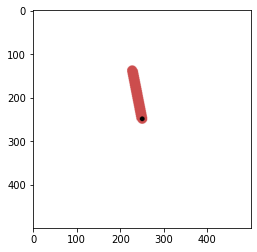

In [18]:
plt.imshow(tensordict.get("pixels").numpy())

Let's have a look at what the tensordict contains:

In [19]:
tensordict

TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([500, 500, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

We still have a `"state"` that describes what `"observation"` used to describe in the previous case (the naming difference comes from the fact that gym now returns a dictionary and TorchRL gets the names from the dictionary if it exists, otherwise it names the step output `"observation"`: in a few words, this is due to inconsistencies in the object type returned by gym environment step method).

One can also discard this supplementary output by asking for the pixels only:

In [20]:
env = GymEnv("Pendulum-v1", from_pixels=True, pixels_only=True)
env.reset()
env.close()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


Some environments only come in image-based format

In [21]:
env = GymEnv("ALE/Pong-v5")
print('from pixels: ', env.from_pixels)
print('tensordict: ', env.reset())
env.close()

from pixels:  True
tensordict:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([210, 160, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


___
## DeepMind Control environments

To run this part of the tutorial, make sure you have installed dm_control:

```
pip install dm_control
```

Make sure also to restart the notebook in between this demo and the previous, as gym and dm_control rendering can conflict.

We also provide a wrapper for DM Control suite. Again, building an environment is easy: first let's look at what environments can be accessed. The `available_envs` now returns a dict of envs and possible tasks:

In [22]:
from torchrl.envs.libs.dm_control import DMControlEnv
from matplotlib import pyplot as plt
DMControlEnv.available_envs

{'acrobot': ['swingup', 'swingup_sparse'],
 'ball_in_cup': ['catch'],
 'cartpole': ['balance',
  'balance_sparse',
  'swingup',
  'swingup_sparse',
  'three_poles',
  'two_poles'],
 'cheetah': ['run'],
 'finger': ['spin', 'turn_easy', 'turn_hard'],
 'fish': ['upright', 'swim'],
 'hopper': ['stand', 'hop'],
 'humanoid': ['stand', 'walk', 'run', 'run_pure_state'],
 'manipulator': ['bring_ball', 'bring_peg', 'insert_ball', 'insert_peg'],
 'pendulum': ['swingup'],
 'point_mass': ['easy', 'hard'],
 'reacher': ['easy', 'hard'],
 'swimmer': ['swimmer6', 'swimmer15'],
 'walker': ['stand', 'walk', 'run'],
 'dog': ['fetch', 'run', 'stand', 'trot', 'walk'],
 'humanoid_CMU': ['run', 'stand'],
 'lqr': ['lqr_2_1', 'lqr_6_2'],
 'quadruped': ['escape', 'fetch', 'run', 'walk'],
 'stacker': ['stack_2', 'stack_4']}

In [23]:
env = DMControlEnv('acrobot', 'swingup')
tensordict = env.reset()
print('result of reset: ', tensordict)
env.close()

result of reset:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        orientations: Tensor(torch.Size([4]), dtype=torch.float64),
        velocity: Tensor(torch.Size([2]), dtype=torch.float64)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


Of course we can also use pixel-based environments:

result of reset:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([240, 320, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


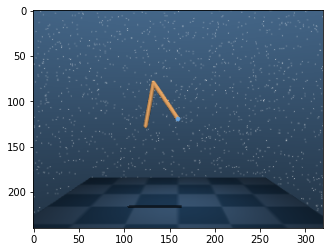

In [24]:
from torchrl.envs.libs.dm_control import DMControlEnv
env = DMControlEnv('acrobot', 'swingup', from_pixels=True, pixels_only=True)
tensordict = env.reset()
print('result of reset: ', tensordict)
plt.imshow(tensordict.get("pixels").numpy())
env.close()

___
## Transforming envs

It is common to pre-process the output of an environment before having it read by the policy or stored in a buffer.

In many instances, the RL community has adopted a wrapping scheme of the type

```
env_transformed = wrapper1(wrapper2(env))
```

to transform environments. This has numerous advantages: it makes accessing the environment specs obvious (the outer wrapper is the source of truth for the external world), and it makes it easy to interact with vectorized environment.
However it also makes it hard to access inner environments: say one wants to remove a wrapper (e.g. `wrapper2`) from the chain, this operation requires us to collect
```
env0 = env.env.env
env_transformed_bis = wrapper1(env0)
```

TorchRL takes the stance of using sequences of transforms instead, as it is done in other pytorch domain libraries (e.g. `torchvision`). This approach is also similar to the way distributions are transformed in `torch.distribution`, where a `TransformedDistribution` object is built around a `base_dist` distribution and (a sequence of) `transforms`.

In [1]:
from torchrl.envs.libs.dm_control import DMControlEnv
import torch
from torchrl.envs.transforms import TransformedEnv, ToTensorImage
# ToTensorImage transforms a numpy-like image into a tensor one, 
env = DMControlEnv('acrobot', 'swingup', from_pixels=True, pixels_only=True)
print('reset before transform: ', env.reset())

env = TransformedEnv(env, ToTensorImage())
print('reset after transform: ', env.reset())
env.close()

reset before transform:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([240, 320, 3]), dtype=torch.uint8)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
reset after transform:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([3, 240, 320]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


To compose transforms, simply use the `Compose` class:

In [2]:
from torchrl.envs.transforms import Compose, Resize
env = DMControlEnv('acrobot', 'swingup', from_pixels=True, pixels_only=True)
env = TransformedEnv(env, Compose(ToTensorImage(), Resize(32, 32)))
env.reset()

TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([3, 32, 32]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

Transforms can also be added one at a time:

In [3]:
from torchrl.envs.transforms import GrayScale
env.append_transform(GrayScale())
env.reset()

TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([1, 32, 32]), dtype=torch.float32)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)

As expected, the metadata get updated too:

In [4]:
print('original obs spec: ', env.base_env.observation_spec)
print('current obs spec: ', env.observation_spec)

original obs spec:  CompositeSpec(
    next_pixels: NdUnboundedDiscreteTensorSpec(
         shape=(240, 320, 3), space=ContinuousBox(minimum=tensor([[[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             ...,
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]],

            [[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             ...,
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]],

            [[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             ...,
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]],

            ...,

            [[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             ...,
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]],

            [[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             ...,
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]],

            [[0, 0, 0],
 

TypeError: Input image tensor permitted channel values are [3], but found240

We can also concatenate tensors if needed:

In [5]:
from torchrl.envs.transforms import CatTensors
env = DMControlEnv('acrobot', 'swingup')
print("keys before concat: ", env.reset())
# make sure to work with "next_key" as this is what step will return
env = TransformedEnv(env, CatTensors(keys_in=["next_orientations", "next_velocity"], out_key="next_observation"))
print("keys after concat: ", env.reset())

keys before concat:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        orientations: Tensor(torch.Size([4]), dtype=torch.float64),
        velocity: Tensor(torch.Size([2]), dtype=torch.float64)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
keys after concat:  TensorDict(
    fields={
        done: Tensor(torch.Size([1]), dtype=torch.bool),
        observation: Tensor(torch.Size([6]), dtype=torch.float64)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


This feature makes it easy to mofidy the sets of transforms applied to an environment input and output.
In fact, transforms are run both before and after a step is executed: for the pre-step pass, the `keys_inv_in` list of keys will be passed to the `_inv_apply_transform` method. An example of such a transform would be to transform floating-point actions (output from a neural network) to the double dtype (requires by the wrapped environment).
After the step is executed, the `_apply_transform` method will be executed on the keys indicated by the `keys_in` list of keys. 

Another interesting feature of the environment transforms is that they allow the user to retrieve the equivalent of `env.env` in the wrapped case, or in other words the parent environment.
The parent environment can be retrieved by calling `transform.parent`: the returned environment will consist in a `TransformedEnvironment` with all the transforms up to (but not including) the current transform. 
This is be used for instance in the `NoopResetEnv` case, which when reset executes the following steps: resets the parent environment before executing a certain number of steps at random in that environment.

In [6]:
env = DMControlEnv('acrobot', 'swingup')
env = TransformedEnv(env)
env.append_transform(CatTensors(keys_in=["next_orientations", "next_velocity"], out_key="next_observation"))
env.append_transform(GrayScale())
print("env: \n", env)
print("GrayScale transform parent env: \n", env.transform[1].parent)
print("CatTensors transform parent env: \n", env.transform[0].parent)

env: 
 TransformedEnv(env=DMControlEnv(env=acrobot, task=swingup, batch_size=torch.Size([])), transform=Compose(
        CatTensors(in_keys=['next_orientations', 'next_velocity'], out_key=next_observation),
        GrayScale(keys=['next_pixels'])))
GrayScale transform parent env: 
 TransformedEnv(env=DMControlEnv(env=acrobot, task=swingup, batch_size=torch.Size([])), transform=Compose(
        CatTensors(in_keys=['next_orientations', 'next_velocity'], out_key=next_observation)))
CatTensors transform parent env: 
 TransformedEnv(env=DMControlEnv(env=acrobot, task=swingup, batch_size=torch.Size([])), transform=Compose(
))


___
## Environment device
Transforms can work on device, which can bring a significant speedup when operations are moderetely or highly computationally demanding. These include `ToTensorImage`, `Resize`, `GrayScale` etc. 

One could legitimately ask what that implies on the wrapped environment side. Very little for regular environments: the operations will still happen on the device where they're supposed to happen. The environment device attribute in torchrl indicates on which device is the incoming data supposed to be and on which device the output data will be. Casting from and to that device is the responsibility of the torchrl environment class. The big advantage of storing data on GPU is (1) speedup of transforms as mentioned above and (2) sharing data amongst workers in multiprocessing settings.


In [7]:
import torch
from torchrl.envs.libs.dm_control import DMControlEnv
from torchrl.envs.transforms import CatTensors, GrayScale, TransformedEnv
env = DMControlEnv('acrobot', 'swingup')
env = TransformedEnv(env)
env.append_transform(CatTensors(keys_in=["next_orientations", "next_velocity"], out_key="next_observation"))

if torch.has_cuda and torch.cuda.device_count():
    env.to('cuda:0')
    env.reset()

___
## Running environments in parallel

TorchRL provides utilities to run environment in parallel. It is expected that the various environment read and return tensors of similar shapes and dtypes (but one could design masking functions to make this possible in case those tensors differ in shapes). Creating such environments is quite easy. Let us look at the simplest case:

In [8]:
from torchrl.envs import ParallelEnv, SerialEnv
from torchrl.envs.libs.gym import GymEnv
env_make = lambda: GymEnv("Pendulum-v1")
parallel_env = ParallelEnv(3, env_make)  # -> creates 3 envs in parallel
parallel_env = ParallelEnv(3, [env_make, env_make, env_make])  # similar to the previous command

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


The `SerialEnv` class is similar to the `ParallelEnv` except for the fact that environments are run sequentially. This is mostly useful for debugging purposes.

`ParallelEnv` instances are created in lazy mode: the environment will start running only when called. This allows us to move `ParallelEnv` objects from process to process without worring too much about running processes.
A `ParallelEnv` can be started by calling `start`, `reset` or simply by calling `step` (if `reset` does not need to be called first).

In [9]:
parallel_env.reset()

LazyStackedTensorDict(
    fields={
        done: Tensor(torch.Size([3, 1]), dtype=torch.bool),
        observation: Tensor(torch.Size([3, 3]), dtype=torch.float32)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)

One can check that the parallel environment has the right batch size. Conventionally, the first part of the `batch_size` indicates the batch, the second the time frame. Let's check that with the `rollout` method:

In [10]:
parallel_env.rollout(max_steps=20)

TensorDict(
    fields={
        action: Tensor(torch.Size([3, 20, 1]), dtype=torch.float32),
        done: Tensor(torch.Size([3, 20, 1]), dtype=torch.bool),
        next_observation: Tensor(torch.Size([3, 20, 3]), dtype=torch.float32),
        observation: Tensor(torch.Size([3, 20, 3]), dtype=torch.float32),
        reward: Tensor(torch.Size([3, 20, 1]), dtype=torch.float32)},
    batch_size=torch.Size([3, 20]),
    device=cpu,
    is_shared=False)

### Closing parallel environments

**Important**: before closing a program, it is important to close the parallel environment. In general, even with regular environments, it is good practice to close a function with a call to `close`. In some instances, TorchRL will throw an error if this is not done (and often it will be at the end of a program, when the environment gets out of scope!)

In [11]:
parallel_env.close()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


### Seeding
When seeding a parallel environment, the difficulty we face is that we don't want to provide the same seed to all environments. The heuristic used by TorchRL is that we produce a  deterministic chain of seeds given the input seed in a -- so to say -- Markovian way, such that it can be reconstructed from any of its elements. All `set_seed` methods will return the next seed to be used, such that one can easily keep the chain going given the last seed. This is useful when several collectors all contain a `ParallelEnv` instance and we want each of the sub-sub-environments to have a different seed.

In [12]:
out_seed = parallel_env.set_seed(10)
print(out_seed)

3288080526


### Accessing environment attributes
It sometimes occurs that a wrapped environment has an attribute that is of interest. 
First, note that TorchRL environment wrapper constains the toolings to access this attribute. Here's an example:

In [13]:
from uuid import uuid1
from time import sleep
def env_make():
    env = GymEnv("Pendulum-v1")
    env._env.foo = f"bar_{uuid1()}"
    env._env.get_something = lambda r: r+1    
    return env
env = env_make()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


In [14]:
# goes through env._env
env.foo

'bar_542ef942-3257-11ed-b93c-aa665a2328e0'

In [15]:
parallel_env = ParallelEnv(3, env_make)  # -> creates 3 envs in parallel
# env has not been started --> error:
try:
    parallel_env.foo
except:
    print("Aargh what did I do!")
    sleep(10)  # make sure we don't get ahead of ourselves

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Aargh what did I do!


In [16]:
parallel_env.start()
foo_list = parallel_env.foo

In [17]:
foo_list  # needs to be instantiated, for instance using list

In [18]:
list(foo_list)

['bar_5cdf70ee-3257-11ed-acfd-aa665a2328e0',
 'bar_5cdf70da-3257-11ed-8393-aa665a2328e0',
 'bar_5cdf7102-3257-11ed-8191-aa665a2328e0']

Similarly, methods can also be accessed:

In [19]:
something = parallel_env.get_something(0)
something

[1, 1, 1]

In [20]:
parallel_env.close()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.


### kwargs for parallel environments

One may want to provide kwargs to the various environments. This can achieved either at construction time or afterwards:

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]



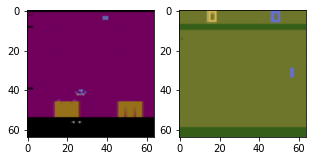

In [22]:
from torchrl.envs import ParallelEnv, TransformedEnv, ToTensorImage, Resize, Compose
from torchrl.envs.libs.gym import GymEnv
from matplotlib import pyplot as plt

def env_make(env_name):
    env = TransformedEnv(GymEnv(env_name, from_pixels=True, pixels_only=True), Compose(ToTensorImage(), Resize(64, 64)))
    return env

parallel_env = ParallelEnv(2, [env_make, env_make], [{"env_name": "ALE/AirRaid-v5"}, {"env_name": "ALE/Pong-v5"}])
tensordict = parallel_env.reset()

plt.figure(figsize=(5, 10))
plt.subplot(121)
plt.imshow(tensordict[0].get("pixels").permute(1, 2, 0).numpy())
plt.subplot(122)
plt.imshow(tensordict[1].get("pixels").permute(1, 2, 0).numpy())
parallel_env.close()

## Transforming parallel environments

There are two equivalent ways of transforming parallen environments: in each process separately, or on the main process. It is even possible to do both. One can therefore think carefully about the transform design to leverage the device capabilities (e.g. transforms on cuda devices) and vectorizing operations on the main process if possible.

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


grayscale tensordict:  LazyStackedTensorDict(
    fields={
        done: Tensor(torch.Size([2, 1]), dtype=torch.bool),
        pixels: Tensor(torch.Size([2, 1, 64, 64]), dtype=torch.float32)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=False)


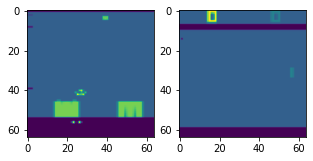

In [23]:
from torchrl.envs import ParallelEnv, TransformedEnv, ToTensorImage, Resize, Compose, GrayScale
from torchrl.envs.libs.gym import GymEnv
from matplotlib import pyplot as plt

def env_make(env_name):
    env = TransformedEnv(GymEnv(env_name, from_pixels=True, pixels_only=True), Compose(ToTensorImage(), Resize(64, 64)))  # transforms on remote processes
    return env

parallel_env = ParallelEnv(2, [env_make, env_make], [{"env_name": "ALE/AirRaid-v5"}, {"env_name": "ALE/Pong-v5"}])
parallel_env = TransformedEnv(parallel_env, GrayScale())  # transforms on main process
tensordict = parallel_env.reset()
print("grayscale tensordict: ", tensordict)
plt.figure(figsize=(5, 10))
plt.subplot(121)
plt.imshow(tensordict[0].get("pixels").permute(1, 2, 0).numpy())
plt.subplot(122)
plt.imshow(tensordict[1].get("pixels").permute(1, 2, 0).numpy())
parallel_env.close()

## VecNorm

In RL, we commonly face the problem of normalizing data before inputting them into a model. 
Sometimes, we can get a good approximation of the normalizing statistics from data gathered in the environment with, say, a random policy (or demonstrations). It might, however, be advisable to normalize the data "on-the-fly", updating the normalizing constants progressively to what has been observed so far. This is particularily useful when we expect the normalizing statistics to change following changes in performance in the task, or when the environment is evolving due to external factors.

**Caution**: this feature should be used with caution with off-policy learning, as old data will be "deprecated" due to its normalization with previously valid normalizing statistics. In on-policy settings too, this feature makes learning non-steady and may have unexpected effects. One would therefore advice users to rely on this feature with caution and compare it with data normalizing given a fixed version of the normalizing constants.

In regular setting, using VecNorm is quite easy:

In [24]:
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.transforms import VecNorm, TransformedEnv

env = TransformedEnv(GymEnv("Pendulum-v1"), VecNorm())
tensordict = env.rollout(max_steps=100)

print("mean: :", tensordict.get("observation").mean(0))  # Approx 0
print("std: :", tensordict.get("observation").std(0))  # Approx 1

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
mean: : tensor([-0.2824, -0.3740, -0.1690])
std: : tensor([0.9514, 1.0710, 1.1238])


In **parallel envs** things are slightly more complicated, as we need to share the running statistics amongst the processes. We created a class `EnvCreator` that is responsible for looking at an environment creation method, retrieving tensordicts to share amongst processes in the environment class, and pointing each process to the right common, shared tensordict once created:

In [28]:
from torchrl.envs import EnvCreator, ParallelEnv
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.transforms import VecNorm, TransformedEnv

make_env = EnvCreator(lambda: TransformedEnv(GymEnv("CartPole-v1"), VecNorm(decay=1.0)))
env = ParallelEnv(3, make_env)
make_env.state_dict()['_extra_state']['td']["next_observation_count"].fill_(0.0)
make_env.state_dict()['_extra_state']['td']["next_observation_ssq"].fill_(0.0)
make_env.state_dict()['_extra_state']['td']["next_observation_sum"].fill_(0.0)

tensordict = env.rollout(max_steps=5)

print('tensordict: ', tensordict)
print("mean: :", tensordict.get("observation").view(-1, 3).mean(0))  # Approx 0
print("std: :", tensordict.get("observation").view(-1, 3).std(0))  # Approx 1

# The count is slightly higher than the number of steps (since we did not use any decay)
# The difference between the two is due to the fact that ParallelEnv creates a dummy environment to initialize the shared TensorDict 
# that is used to collect data from the dispached environments. This small difference will usually be absored throughout training.
print("update counts: ", make_env.state_dict()['_extra_state']['td']["next_observation_count"])
env.close()

Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
tensordict:  TensorDict(
    fields={
        action: Tensor(torch.Size([3, 5, 2]), dtype=torch.int64),
        done: Tensor(torch.Size([3, 5, 1]), dtype=torch.bool),
        next_observation: Tensor(torch.Size([3, 5, 4]), dtype=torch.float32),
        observation: Tensor(torch.Size([3, 5, 4]), dtype=torch.float32),
        reward: Tensor(torch.Size([3, 5, 1]), dtype=torch.float32)},
    batch_size=torch.Size([3, 5]),
    device=cpu,
    is_shared=False)
mean: : tensor([ 0.1187, -0.0427, -0.1390])
std: : tensor([1.1470, 1.1814, 1.1676])
update counts:  tensor([18.])
Discarding frameskip arg. This will be taken care of by TorchRL env wrapper.
Discarding frameskip arg. This will be tak